In [1]:
import pandas as pd
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import folium
import json
import numpy as np
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Load the data

In [2]:
# bus stops in Kingston
bus_stops = pd.read_csv("./bus-stops.csv")

# parking areas for cars [public/private] for park and ride
parking = pd.read_csv("./parking-areas.csv")

# biking paths
cycling_paths = pd.read_csv("./cycling-facilities.csv")

# civic addresses
civic_addresses = pd.read_csv("./civic-addresses.csv")

# Perform Preprocessing

## Bus Stops

In [3]:
# for the bus stops, all that is needed is the coordinate locations and the IDs (to help with debugging), the rest can be dropped
bus_stops = bus_stops.drop(columns=["Code", "Name", "Description", "Zone ID", "URL", "Location Type", "Parent Station ID", "Timezone", "Wheelchair Boarding"])

In [4]:
# coordinates should be lists of floats or dictionary, not strings
print(bus_stops["Coordinates"][0])

44.25722, -76.57395


In [5]:
# now we can properly check for null values and see that there are none!
bus_stops.isnull().any()

ID             False
Coordinates    False
dtype: bool

In [6]:
# finally for bus stops, since each coordinate is a string, let's fix that
bus_stops["Coordinates"] = bus_stops["Coordinates"].apply(lambda bus_stop_coords: [float(coord) for coord in bus_stop_coords.split(",")])

## Parking

In [7]:
# we will perform the similar steps as we did for bus_stops on the parking area data
# in this case we want to keep the PARKING_AREA_ID, GeoJSON and geo_point_2d, we can discard the rest of the features as we only need geographical features + the id
parking = parking.drop(columns=["DESCRIPTION", '﻿"MATERIAL"'])

In [8]:
parking.isnull().any()

PARKING_AREA_ID    True
GeoJSON            True
geo_point_2d       True
dtype: bool

In [9]:
# unlike last time, there are rows where GeoJSON or geo_point_2d is null. For parking lots, GeoJSON is essential as we want to map out the parking lot spaces
# for this reason, we will drop the rows where GeoJSON is missing
parking = parking[~parking['GeoJSON'].isnull()]

In [10]:
# there is now no rows with GeoJSON or geo_point_2d being null, a null PARKING_AREA_ID is fine so the data is now ready!!
parking.isnull().any()

PARKING_AREA_ID     True
GeoJSON            False
geo_point_2d       False
dtype: bool

In [11]:
# since each coordinate is a string and our GeoJSON data is a string, we will conver them to a list of floats and a dictionary respectively
parking["geo_point_2d"] = parking["geo_point_2d"].apply(lambda parking_coords: [float(coord) for coord in parking_coords.split(",")])
parking["GeoJSON"] = parking["GeoJSON"].apply(lambda parking_coords: json.loads(parking_coords))

## Cycling

In [12]:
# we will now remove the features we don't require from cycling_paths
cycling_paths = cycling_paths.drop(columns=["CYCLE_STATUS", "CYCLE_TYPE", "CONSTRUCTION_STATUS", "CONSTRUCTION_TYPE", "CYCLE_WIDTH"])

In [13]:
# there are no null values so we can move on safely
cycling_paths.isnull().any()

GeoJSON         False
geo_point_2d    False
dtype: bool

In [14]:
# since each coordinate is a string and our GeoJSON data is a string, we will conver them to a list of floats and a dictionary respectively
cycling_paths["geo_point_2d"] = cycling_paths["geo_point_2d"].apply(lambda cycling_coords: [float(coord) for coord in cycling_coords.split(",")])
cycling_paths["GeoJSON"] = cycling_paths["GeoJSON"].apply(lambda cycling_coords: json.loads(cycling_coords))

## Civic Addresses

In [15]:
# we will repeat the same steps as before
civic_addresses = civic_addresses.drop(columns=["ADDRESS_NUMBER", "STREET_BODY_NAME", "STREET_TYPE_SUFFIX", "DIRECTION_SUFFIX", "ADDRESS_NUMBER_SUFFIX",	'﻿"MUNICIPALITY"', "UNIT_TYPE", "UNIT",	"STREET", "FULL_ADDRESS", "GARBAGE_DAY", "ELECTORAL_DISTRICT_NAME", "NEIGHBOURHOOD", "RECYCLING_DAY", "POSTAL_CODE", "ADDRESS_ID"])

In [16]:
# there are no null values so we are safe to proceed
civic_addresses.isnull().any()

GeoJSON         False
geo_point_2d    False
dtype: bool

In [17]:
# since each coordinate is a string and our GeoJSON data is a string, we will conver them to a list of floats and a dictionary respectively
civic_addresses["geo_point_2d"] = civic_addresses["geo_point_2d"].apply(lambda coords: [float(coord) for coord in coords.split(",")])
civic_addresses["GeoJSON"] = civic_addresses["GeoJSON"].apply(lambda coords: json.loads(coords))

# Graphing and Analyzing for Parking

In [18]:
# compute how many bus stops are within 250m of a parking lot
counts = []
for index, parking_row in parking.iterrows():
    count = 0
    for index_2, bus_stop in bus_stops.iterrows():
        dist = haversine(parking_row["geo_point_2d"], bus_stop["Coordinates"], unit=Unit.METERS)
        if dist < 250:
            count += 1    
    
    counts.append(count)

In [19]:
# update the parking dataframe to include the number of bus stops nearby
parking["stops_nearby"] = counts

In [20]:
# map the parking locations with red if there's no bus stops nearby and green otherwise
m = folium.Map(location=[44.255457210079605, -76.57542256523625	], zoom_start=13, tiles="OpenStreetMap")

for index, row in parking.iterrows():
    if row["stops_nearby"] == 0:
        color =  "#e51f1f" 
    else:
        color = "#013220"

    folium.GeoJson(row['GeoJSON'], style_function=lambda x, color=color: {'color': color, 'weight': 0.5, 'fillOpacity': 1}).add_to(m)

In [21]:
m

# Analyzing Cycling Paths

In [22]:
# compute which bus stops are near which cycling sections (broken up into line segments!)

dist_to_nearest_bus_stop_per_segment = []
for _, cycling_row in cycling_paths.iterrows():
    min_dist = 1000000000000
    for _, bus_stop in bus_stops.iterrows():
        min_dist = min(haversine(bus_stop["Coordinates"], cycling_row["geo_point_2d"], unit=Unit.METERS), min_dist)
    dist_to_nearest_bus_stop_per_segment.append(min_dist)

In [29]:
dist_to_nearest_bus_stop_per_segment_df = pd.DataFrame(dist_to_nearest_bus_stop_per_segment)
bins = [0, 100,200, 300, 400, 500, 600, 700, 800, 900, 1000, np.inf]
labels = ["0-100","100-200","200-300","300-400", "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000", ">1000"]
dist_to_nearest_bus_stop_per_segment_df = pd.cut(dist_to_nearest_bus_stop_per_segment_df[dist_to_nearest_bus_stop_per_segment_df.columns[0]], bins=bins, labels=labels)

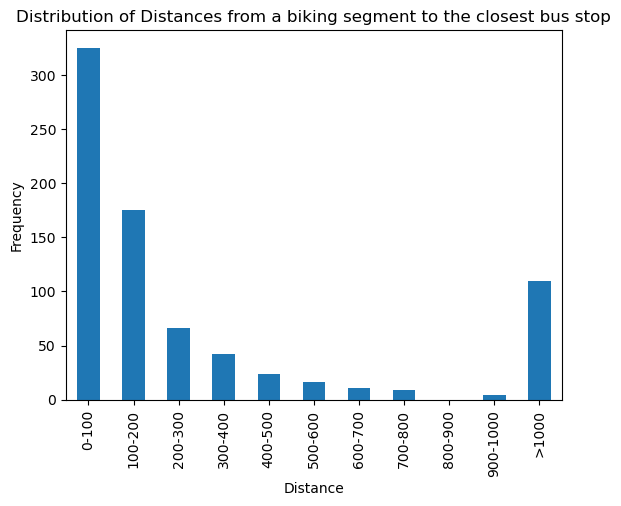

In [30]:
dist_to_nearest_bus_stop_per_segment_df.value_counts().sort_index().plot(kind="bar")
plt.title('Distribution of Distances from a biking segment to the closest bus stop')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Analyzing Walking

In [25]:
# compute how close each civic address is to a bus stop
destinations = MultiPoint([Point(bus_stop) for bus_stop in bus_stops["Coordinates"]])

dists = []
for _, address in civic_addresses.iterrows():
    nearest_bus_stop = nearest_points(Point(address["geo_point_2d"]), destinations)
    point_from_shapely = [list(x)[0] for x in list(nearest_bus_stop[1].xy)]
    min_dist = haversine(point_from_shapely, address["geo_point_2d"], unit=Unit.METERS)
    dists.append(min_dist)

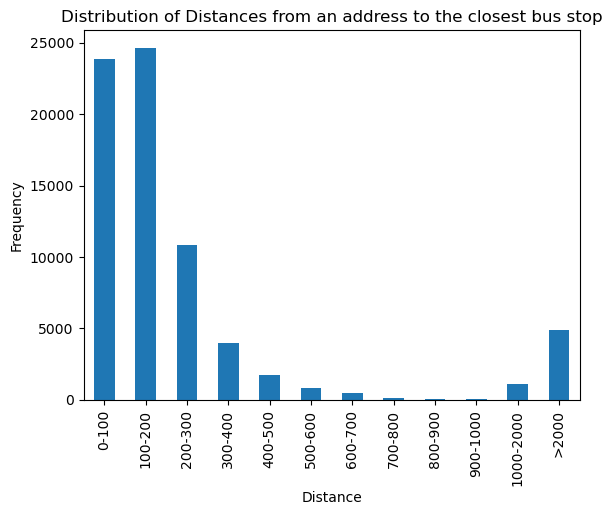

In [26]:
dists_df = pd.DataFrame(dists)
bins = [0, 100,200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, np.inf]
labels = ["0-100","100-200","200-300", "300-400", "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000", "1000-2000", ">2000"]
dists_df = pd.cut(dists_df[dists_df.columns[0]], bins=bins, labels=labels)
dists_df.value_counts().sort_index().plot(kind="bar")
plt.title('Distribution of Distances from an address to the closest bus stop')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()